In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

In [2]:
# spacy.load('en')

In [3]:
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df=pd.read_csv("hindu_articles.csv")

In [5]:
df.head()

,name,date,location,category,author,body
0,Juvenile users of Chinese gay app contract HIV,"January 06, 2019",Health,"Sci-Tech,Health",NaN,Chinese gay dating app Blued is halting new us...
1,21dcangr-ctte-cGNE54S5ME3jpgjpg,"December 28, 2018",DOWN TOWN,"Today's Paper,FEATURES,DOWN TOWN",NaN,Students stage a dance based on the theme of HIV.
2,A year that saw Tamil Nadu's health sector sta...,"December 30, 2018",Tamil Nadu,"News,States,Tamil Nadu",Serena Josephine M,The year was one of ups and downs for the heal...
3,‘Many combination drugs not approved by regula...,"December 11, 2018",NATIONAL,"Today's Paper,NATIONAL",Afshan Yasmeen,Of the 110 anti-TB (tuberculosis) Fixed Dose C...
4,HIV reality check,"December 31, 2018",OPINION,"Today's Paper,OPINION",NaN,A 23-year-old pregnant woman in Tamil Nadu tes...


In [6]:
data=df.name.values.tolist()

In [7]:
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Juvenile users of Chinese gay app contract HIV']


<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:4: DeprecationWarning: invalid escape sequence \s
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:4: DeprecationWarning: invalid escape sequence \s
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:4: DeprecationWarning: invalid escape sequence \s
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:4: DeprecationWarning: invalid escape sequence \s
<input>:1: Dep

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['juvenile', 'users', 'of', 'chinese', 'gay', 'app', 'contract', 'hiv']]


In [9]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['juvenile user chinese gay app contract hiv', 'dcangr ctte cgne jpgjpg']


In [10]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [11]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.22130170744439126 %


In [30]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_topics=2,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,                # Use all available CPUs
                                      learning_decay=0.9  
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

/Users/shefalibansal/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=2, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [31]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -445164.8649456368
Perplexity:  641.4012641896486
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.9,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 2,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [12]:
# Define Search Param
search_params = {'n_components': [2, 3, 4, 5, 6], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

/Users/shefalibansal/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/shefalibansal/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/shefalibansal/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/shefalibansal/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_metho

/Users/shefalibansal/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/shefalibansal/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/shefalibansal/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/shefalibansal/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_metho

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [2, 3, 4, 5, 6], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [20]:
# GridSearchCV(cv=None, error_score='raise',
#        estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
#              evaluate_every=-1, learning_decay=0.7, learning_method=None,
#              learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
#              mean_change_tol=0.001, n_components=10, n_jobs=1,
#              n_topics=None, perp_tol=0.1, random_state=None,
#              topic_word_prior=None, total_samples=1000000.0, verbose=0),
#        fit_params=None, iid=True, n_jobs=1,
#        param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
#        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
#        scoring=None, verbose=0)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [13]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 2}
Best Log Likelihood Score:  -154460.0809703974
Model Perplexity:  621.4945961859038


In [18]:
best_lda_model

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=2, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

/Users/shefalibansal/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/shefalibansal/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/shefalibansal/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


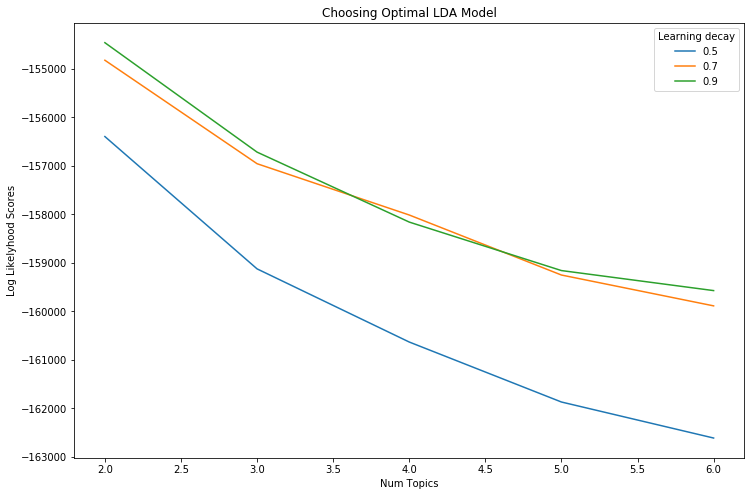

In [14]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [2, 3, 4, 5, 6]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [20]:
best_lda_model.n_components

2

In [21]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,dominant_topic
Doc0,0.91,0.09,0
Doc1,0.75,0.25,0
Doc2,0.92,0.08,0
Doc3,0.9,0.1,0
Doc4,0.87,0.13,0
Doc5,0.17,0.83,1
Doc6,0.17,0.83,1
Doc7,0.17,0.83,1
Doc8,0.87,0.13,0
Doc9,0.25,0.75,1


In [22]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,11263
1,1,10213


In [23]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=           Freq  cluster  topics            x           y
topic                                                    
0      51.74299        1       1  2352.815430 -5514.87207
1      48.25701        1       2 -2352.815186  5514.87207, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
591   Default  3548.000000          hiv  3548.000000  30.0000  30.0000
1305  Default  1171.000000        today  1171.000000  29.0000  29.0000
101   Default   830.000000    awareness   830.000000  28.0000  28.0000
669   Default   811.000000          jpg   811.000000  27.0000  27.0000
40    Default  2437.000000          aid  2437.000000  26.0000  26.0000
215   Default   698.000000        child   698.000000  25.0000  25.0000
211   Default   562.000000      chennai   562.000000  24.0000  24.0000
404   Default   596.000000         drug   596.000000  23.0000  23.0000
576   Default   557.000000       health   557.000000  22.0000  22.0000
959   Default   562.000000     positive   562.000000  21.0000  21.0000
330   Default   455.000000          day   455.000000  20.0000  20.0000
916   Default   494.000000      patient   494.000000  19.0000  19.0000
140   Default   472.000000        blood   472.000000  18.0000  18.0000
856   Default   440.000000          new   440.000000  17.0000  17.0000
996   Default   345.000000    programme   345.000000  16.0000  16.0000
200   Default   379.000000       centre   379.000000  15.0000  15.0000
189   Default   358.000000         case   358.000000  14.0000  14.0000
1050  Default   317.000000          red   317.000000  13.0000  13.0000
1427  Default   307.000000        world   307.000000  12.0000  12.0000
599   Default   306.000000     hospital   306.000000  11.0000  11.0000
1087  Default   269.000000       ribbon   269.000000  10.0000  10.0000
592   Default   238.000000         hold   238.000000   9.0000   9.0000
1137  Default   259.000000         seek   259.000000   8.0000   8.0000
1029  Default   230.000000        rally   230.000000   7.0000   7.0000
1290  Default   251.000000         test   251.000000   6.0000   6.0000
1425  Default   226.000000       worker   226.000000   5.0000   5.0000
1153  Default   224.000000          sex   224.000000   4.0000   4.0000
729   Default   314.000000         life   314.000000   3.0000   3.0000
228   Default   213.000000         city   213.000000   2.0000   2.0000
708   Default   233.000000       launch   233.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
791    Topic2   154.831715         meet   155.630995   0.7235  -5.3690
434    Topic2    94.236681   engagement    94.784505   0.7228  -5.8656
1193   Topic2   111.407668      society   112.064763   0.7227  -5.6982
944    Topic2    93.548923         play    94.114810   0.7226  -5.8729
179    Topic2    86.728603       campus    87.258338   0.7225  -5.9486
1364   Topic2   137.626499      vaccine   138.495141   0.7223  -5.4868
1102   Topic2    91.919410          rte    92.506078   0.7223  -5.8905
1234   Topic2    85.271249        story    85.828731   0.7221  -5.9655
486    Topic2   206.525926        fight   207.933534   0.7218  -5.0809
1323   Topic2    95.851234  transgender    96.509267   0.7218  -5.8486
1319   Topic2    85.859923     training    86.450418   0.7218  -5.9587
278    Topic2    72.994796      connect    73.510687   0.7216  -6.1210
1149   Topic2   127.256326      service   128.162373   0.7215  -5.5652
177    Topic2   175.143105         camp   176.687113   0.7199  -5.2458
1247   Topic2   151.654944        study   152.806129   0.7211  -5.3898
99     Topic2   153.623222        award   154.870567   0.7205  -5.3769
309    Topic2   163.494296       create   164.960532   0.7197  -5.3146
1424   Topic2   135.826822         work   136.794768   0.7215  -5.5000
215    Topic2   682.103942        child   698.308483   0.7052  -3.8862
536    Topic2   111.230002       

In [24]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
# View
df_topic_keywords.head()

,aadhaar,aap,abl,abuse,accept,access,accident,accreditation,accuse,achieve,...,worry,worth,wrong,year,yield,yojana,young,youth,youthful,zone
Topic0,0.685199,9.847678,11.093295,34.939557,13.000290,43.887965,16.193383,7.023448,5.050076,0.568514,...,3.255806,0.581822,27.315233,170.901586,10.391222,0.942952,9.432018,25.530984,0.541183,1.135168
Topic1,14.385839,0.546944,0.581034,23.519168,0.564831,0.582156,0.581209,4.703721,12.891274,23.208832,...,24.992013,12.215299,0.928074,35.178802,0.613995,12.795094,49.894519,138.689735,14.097389,12.612678


In [32]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,hiv,jpg,drug,aid,positive,health,patient,blood,new,centre,case,hospital,people,india,woman
Topic 1,aid,today,awareness,child,chennai,day,programme,red,world,life,ribbon,art,hold,rally,worker
